# Benchmark to find threshold for filtering low-variance features

See https://git.bia-christian.de/bia/lab_book_VEO/wiki/feature-selection#remove-low-variance-features

In [57]:
#Turn off scientific notation
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

#Activate print all activities
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [58]:
import pickle
import zstandard
import pandas as pd
import numpy as np
import datetime

print("Started script! Loading input file...", datetime.datetime.now())

#feature = 'kmer9Classification'
feature = 'gene-familiesClassification'
#abiotic_factor = 'salt'
abiotic_factor = 'temperature'
#group = 'Salinity group'
group = 'Temp group'

file1 = '/home/bia/Documents/bacterial_phenotypes/connecting_features_abFactors/df_' + abiotic_factor + '_' + feature + '_selected-filterNA.pickle.zst'  

with zstandard.open(file1, 'rb') as f:
	df = pickle.load(f)

print("Loaded input pickle zst file...", datetime.datetime.now())
df.head()
df.shape

Started script! Loading input file... 2024-07-09 17:01:27.537913
Loaded input pickle zst file... 2024-07-09 17:01:27.972804


,COG3696@2,COG0606@2,33SZW@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,2Z7XP@2,COG1086@2,...,arCOG06650@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1002367.3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,medium
101383.4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,low
1049789.4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,medium
1056810.3,1,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,medium
108980.91,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,medium


(13198, 20142)

In [59]:
#Replace string to int for target variable
#MAKE SURE THE NUMBER OF GROUPS IS CORRECT
df[group] = df[group].replace(['low'], 0)
df[group] = df[group].replace(['medium'], 2)
df[group] = df[group].replace(['high'], 1)

print('Number of isolates with group low:', len(df[df[group] == 0]) )
print('Number of isolates with group medium:', len(df[df[group] == 2]) )
print('Number of isolates with group high:', len(df[df[group] == 1]) )

/tmp/ipykernel_34421/292130860.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[group] = df[group].replace(['high'], 1)


Number of isolates with group low: 334
Number of isolates with group medium: 12414
Number of isolates with group high: 450


In [60]:
#Remove intermediate group to keep only extremes
df = df[df[group] != 2]

In [61]:
import matplotlib.pyplot as plt

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()
df_var = variances.to_frame()
df_var = df_var.rename(columns={0: 'Variance'})

#type(df_var)
len(df_var)
df_var.head()

Shape of the input dataframe: (784, 20142)



20142

,Variance
COG3696@2,0.21
COG0606@2,0.24
33SZW@2,0.00
COG0774@1,0.08
COG5009@2,0.23


In [62]:
df_var['Variance'].min()
df_var['Variance'].max()
df_var['Variance'].mean()
df_var['Variance'].median()

#gene-families Salt:
#0.0
#0.25012518550215324
#0.008712192704809501
#0.0

#gene-families Temp:
#0.0
#0.2500189436993256
#0.010060193776085443
#0.0003030073270520057

#kmer9 Salt:
#0.17948768528718817
#1230913.0201571418
#2929.0422919068724
#474.70714230076277

0.0

0.2503192848020434

0.009352705556105382

0.0

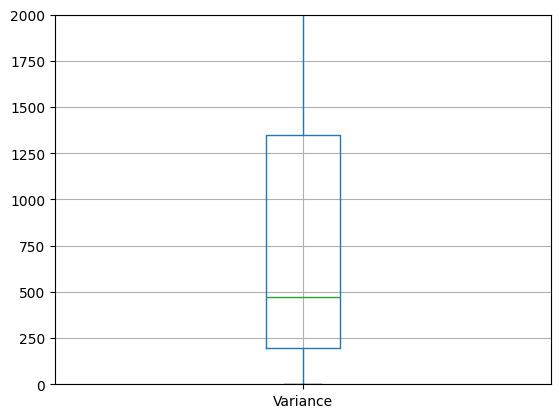

In [15]:
from matplotlib.ticker import ScalarFormatter

boxplot = df_var.boxplot(column='Variance')

#https://www.reddit.com/r/learnpython/comments/el4vbx/how_to_remove_scientific_notation_from_a/
#Remove scientific notation from y-axis
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

# Set y-axis limits
plt.ylim(0, 2000) 

# Show the plot
plt.show();

In [63]:
#Gene-families #########################################

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()

#Identify columns with different variances
for i in np.arange(0, 0.11, 0.01):

    tmp = df.copy()
    
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns), ',', round( (len(zero_variance_columns)/len(tmp.columns))*100, 1 ), '%')

    #Drop zero-variance features
    tmp = tmp.drop(columns=zero_variance_columns)

    tmp.head()
    
    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())
    
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
        pickle.dump(tmp, f)

Shape of the input dataframe: (784, 20142)

 Threshold: 0.0 Number of zero-variance features: 13713 , 68.1 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG05632@2157,"Viruses,4R0IQ@35237",arCOG09713@2157,arCOG07735@2157,arCOG07334@2157,arCOG04203@2157,arCOG01811@2157,arCOG00087@2157,arCOG07496@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 6429)  Any NAs in the dataframe? False
 Threshold: 0.01 Number of zero-variance features: 17650 , 87.6 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG00072@2157,arCOG06002@2157,arCOG03854@2157,arCOG01673@2157,arCOG06001@2157,arCOG05935@2157,arCOG05901@2157,arCOG03863@2157,arCOG03867@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 2492)  Any NAs in the dataframe? False
 Threshold: 0.02 Number of zero-variance features: 18271 , 90.7 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG00643@2157,arCOG00282@2157,arCOG05967@2157,arCOG01496@2157,arCOG02623@2157,arCOG03384@2157,arCOG03665@2157,arCOG00257@2157,arCOG03696@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 1871)  Any NAs in the dataframe? False
 Threshold: 0.03 Number of zero-variance features: 18646 , 92.6 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG01391@2157,arCOG01561@2157,arCOG00174@2157,arCOG03433@2157,arCOG02960@2157,arCOG03284@2157,arCOG00095@2157,arCOG02089@2157,arCOG03665@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 1496)  Any NAs in the dataframe? False
 Threshold: 0.04 Number of zero-variance features: 18852 , 93.6 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG00407@2157,arCOG04297@2157,arCOG01924@2157,arCOG00322@2157,arCOG03661@2157,arCOG01391@2157,arCOG00174@2157,arCOG02960@2157,arCOG03284@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 1290)  Any NAs in the dataframe? False
 Threshold: 0.05 Number of zero-variance features: 19024 , 94.4 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG03771@2157,arCOG01229@2157,arCOG05865@2157,arCOG00749@2157,arCOG01144@2157,arCOG01294@2157,arCOG01533@2157,arCOG05412@2157,arCOG02175@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 1118)  Any NAs in the dataframe? False
 Threshold: 0.06 Number of zero-variance features: 19164 , 95.1 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG15272@2157,arCOG01420@2157,arCOG01937@2157,arCOG05072@2157,arCOG02666@2157,arCOG00709@2157,arCOG05865@2157,arCOG00749@2157,arCOG02175@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 978)  Any NAs in the dataframe? False
 Threshold: 0.07 Number of zero-variance features: 19261 , 95.6 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG01978@2157,arCOG00767@2157,arCOG00018@2157,arCOG02044@2157,arCOG01357@2157,arCOG01672@2157,arCOG01937@2157,arCOG05072@2157,arCOG05865@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 881)  Any NAs in the dataframe? False
 Threshold: 0.08 Number of zero-variance features: 19341 , 96.0 %


,COG3696@2,COG0606@2,COG0774@1,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,...,arCOG04247@2157,arCOG00555@2157,arCOG00321@2157,arCOG00018@2157,arCOG02044@2157,arCOG01357@2157,arCOG01672@2157,arCOG01937@2157,arCOG05072@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,0,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 801)  Any NAs in the dataframe? False
 Threshold: 0.09 Number of zero-variance features: 19417 , 96.4 %


,COG3696@2,COG0606@2,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,COG0342@1,...,arCOG01340@2157,arCOG01951@2157,arCOG01537@2157,arCOG00486@2157,arCOG00555@2157,arCOG00321@2157,arCOG00018@2157,arCOG02044@2157,arCOG01937@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 725)  Any NAs in the dataframe? False
 Threshold: 0.1 Number of zero-variance features: 19490 , 96.8 %


,COG3696@2,COG0606@2,COG5009@2,COG0188@2,COG0265@2,COG3270@1,COG1086@2,COG2244@2,COG1596@2,COG0342@1,...,arCOG00865@2157,arCOG00487@2157,arCOG00410@2157,arCOG01347@2157,arCOG00933@2157,arCOG01340@2157,arCOG01951@2157,arCOG00555@2157,arCOG02044@2157,Temp group
Best assembly,,,,,,,,,,,,,,,,,,,,,
101383.4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111140.3,1,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1123036.3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1218801.3,1,1,1,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
200475.3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Shape of dataframe without zero-variance features: (784, 652)  Any NAs in the dataframe? False


In [16]:
#kmer9 #########################################

#Create files with different thresholds

print("Shape of the input dataframe:", df.shape)
print()

#Calculate variance for each feature/column
variances = df.var()

#Identify columns with different variances
for i in np.arange(0, 1100, 100):

    tmp = df.copy()
    
    zero_variance_columns = variances[variances <= i].index
    #print(zero_variance_columns)

    # Check if the group exists in the Index
    if group in zero_variance_columns:
    
        # Remove the element group, so that the abiotic factor is not accidentally excluded
        zero_variance_columns2 = zero_variance_columns.delete(zero_variance_columns.get_loc(group))
    else:
        zero_variance_columns2 = zero_variance_columns
    
    print(" Threshold:", i, "Number of zero-variance features:", len(zero_variance_columns2), ',', round( (len(zero_variance_columns2)/len(tmp.columns))*100, 1 ), '%')

    #Drop zero-variance features
    tmp = tmp.drop(columns=zero_variance_columns2)

    print(" Shape of dataframe without zero-variance features:", tmp.shape, " Any NAs in the dataframe?", tmp.isnull().any().any())

    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + feature + '_' + str(i) + '.pickle.zst', 'wb') as f:
        pickle.dump(tmp, f)

Shape of the input dataframe: (1989, 131073)

 Threshold: 0 Number of zero-variance features: 0 , 0.0 %
 Shape of dataframe without zero-variance features: (1989, 131073)  Any NAs in the dataframe? False
 Threshold: 100 Number of zero-variance features: 14692 , 11.2 %
 Shape of dataframe without zero-variance features: (1989, 116381)  Any NAs in the dataframe? False
 Threshold: 200 Number of zero-variance features: 33676 , 25.7 %
 Shape of dataframe without zero-variance features: (1989, 97397)  Any NAs in the dataframe? False
 Threshold: 300 Number of zero-variance features: 48125 , 36.7 %
 Shape of dataframe without zero-variance features: (1989, 82948)  Any NAs in the dataframe? False
 Threshold: 400 Number of zero-variance features: 59168 , 45.1 %
 Shape of dataframe without zero-variance features: (1989, 71905)  Any NAs in the dataframe? False
 Threshold: 500 Number of zero-variance features: 67403 , 51.4 %
 Shape of dataframe without zero-variance features: (1989, 63670)  Any NAs

In [149]:
#tmp.head()
#type(zero_variance_columns2)

,AAAAAAAAA,AAAAAAAAC,AAAAAAAAG,AAAAAAAAT,AAAAAAACA,AAAAAAACC,AAAAAAACG,AAAAAAACT,AAAAAAAGA,AAAAAAAGC,...,TTTCTCAAA,TTTGAAAAA,TTTGACAAA,TTTGCAAAA,TTTGCCAAA,TTTGGAAAA,TTTGTAAAA,TTTTAAAAA,TTTTCAAAA,Salinity group
Best assembly,,,,,,,,,,,,,,,,,,,,,
1051501.5,67,146,161,178,407,229,240,146,412,344,...,132,428,113,187,103,135,154,376,393,1
1077675.3,177,210,288,477,432,92,199,231,586,284,...,91,435,105,137,108,195,180,410,372,1
1121909.4,150,162,178,358,297,138,128,175,256,235,...,87,289,49,123,67,181,222,733,352,1
1123237.3,4,5,4,4,3,11,13,5,5,7,...,7,12,12,13,12,14,2,3,5,1
1123508.3,30,53,38,46,76,71,76,47,69,80,...,107,264,140,96,195,177,32,29,226,0


pandas.core.indexes.base.Index

## Benchmark

In [64]:
#Importing packages
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

In [65]:
#Change line below to fit gene families or kmers

#Loop to get different subsample datasets

#Cross-validation packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import statistics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

f1_df = pd.DataFrame()

#Loop for different thresholds for filtering low-variance
for i in np.arange(0, 0.11, 0.01):  
#for i in np.arange(0, 1100, 100):
        
    with zstandard.open('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_' + abiotic_factor + '_' + 
                        feature + '_' + str(i) + '.pickle.zst', 'rb') as f: 
        tmp = pickle.load(f)
    
    print('Calculating metrics for threshold', i, 'of filtering low-variance features...')

    list_means = []

    #Separating features from group/target variable
    X_full = tmp.drop(group, axis=1)
    y_full = tmp[group]
    
    #UNDERSAMPLING
    #Definindo o RandomUnderSampler
    rus = RandomUnderSampler(random_state=5)
    
    # Aplicando para X e y
    X, y = rus.fit_resample(X_full, y_full)
    
    #Do 10 iterations for every different threshold
    for it in range(1, 11, 1):
#    for it in range(1, 3, 1):        

        #Cross-validation
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        #Instantiate Random Forest model
        clf = RandomForestClassifier()

        scoring = ['f1']
        output = cross_validate(clf, X, y, cv=5, scoring = scoring, return_train_score=False, return_estimator =True)

        #Get mean F1 for this iteration
        mean = statistics.mean(output['test_f1'])
        #Add mean F1 to vector containing results of all iterations
        list_means.append(mean)

        print(' Iteration', it, 'has as mean F1 value =', round(mean, 3), 'All values:', output['test_f1'])
    
    print(' Mean F1 score of cross-validation for all iterations:', round(statistics.mean(list_means), 3))

    #Add new values
    f1_df[i] = list_means

Calculating metrics for threshold 0.0 of filtering low-variance features...
 Iteration 1 has as mean F1 value = 0.953 All values: [0.98 0.99 0.98 0.96 0.86]
 Iteration 2 has as mean F1 value = 0.95 All values: [0.98 0.98 0.98 0.96 0.85]
 Iteration 3 has as mean F1 value = 0.956 All values: [0.98 0.99 0.98 0.97 0.86]
 Iteration 4 has as mean F1 value = 0.954 All values: [0.98 1.00 0.98 0.96 0.85]
 Iteration 5 has as mean F1 value = 0.952 All values: [0.98 0.98 0.98 0.96 0.85]
 Iteration 6 has as mean F1 value = 0.956 All values: [0.98 0.99 0.98 0.96 0.86]
 Iteration 7 has as mean F1 value = 0.951 All values: [0.97 0.99 0.98 0.96 0.85]
 Iteration 8 has as mean F1 value = 0.952 All values: [0.98 1.00 0.97 0.96 0.85]
 Iteration 9 has as mean F1 value = 0.953 All values: [0.98 0.99 0.98 0.96 0.85]
 Iteration 10 has as mean F1 value = 0.95 All values: [0.98 1.00 0.98 0.96 0.84]
 Mean F1 score of cross-validation for all iterations: 0.953
Calculating metrics for threshold 0.01 of filtering lo

In [66]:
f1_df

#Save DataFrame to a CSV file
f1_df.to_csv('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/df_f1_benchmark_' + abiotic_factor + '_' + feature + '.csv', index=True)

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
0,0.95,0.96,0.96,0.96,0.95,0.96,0.95,0.96,0.96,0.95,0.95
1,0.95,0.95,0.96,0.95,0.95,0.95,0.95,0.95,0.96,0.96,0.95
2,0.96,0.95,0.95,0.95,0.95,0.96,0.95,0.96,0.95,0.95,0.95
3,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95
4,0.95,0.95,0.95,0.95,0.96,0.95,0.95,0.95,0.96,0.96,0.95
5,0.96,0.96,0.96,0.95,0.96,0.96,0.95,0.96,0.95,0.95,0.96
6,0.95,0.95,0.95,0.95,0.95,0.96,0.95,0.95,0.95,0.95,0.95
7,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.96,0.96,0.95,0.95
8,0.95,0.96,0.95,0.95,0.95,0.95,0.95,0.96,0.95,0.95,0.95
9,0.95,0.95,0.95,0.95,0.95,0.95,0.96,0.96,0.95,0.95,0.95


In [71]:
#cols = f1_df.columns
values = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

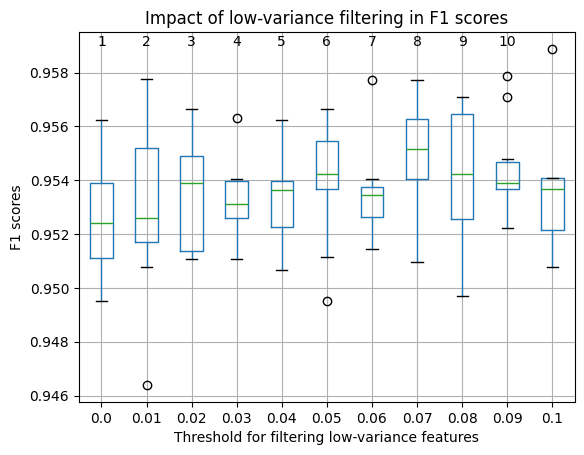

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

#https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

#Balanced groups
# Plot the values on a boxplot
#plt.scatter(f1_df.index, f1_df, color='lightgrey', alpha=0.5)
#plt.scatter(f1_df.values, color='lightgrey', alpha=0.5)

boxplot = f1_df.boxplot();

labels = values
n_cols = len(labels)
draw_at = 0.959
for x, y, l in zip(range(1,n_cols+1), np.repeat(draw_at, n_cols),
labels):
    boxplot.text(x, y, l, horizontalalignment='center')

# Add labels and title
plt.xlabel('Threshold for filtering low-variance features');
plt.ylabel('F1 scores');
plt.title('Impact of low-variance filtering in F1 scores');

plt.savefig('/home/bia/Documents/BacterialData/run_features/benchmark_low-variance_threshold/benchmark_' + abiotic_factor + '_' + feature + '.png', dpi=300)

# Show plot
plt.show();

Text(1, 1.7, 'n=15')

Text(2, 1.7, 'n=12')

Text(3, 1.7, 'n=4')

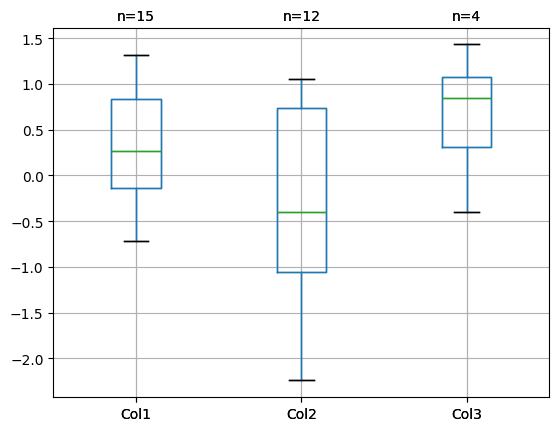

In [70]:
from matplotlib import pyplot as plt
import numpy as np

np.random.seed(1234)
df = pd.DataFrame(np.random.randn(10, 4), columns=['Col1', 'Col2',
'Col3', 'Col4'])

boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])
labels = ["n=15", "n=12", "n=4"]
n_cols = len(labels)
draw_at = 1.7
for x, y, l in zip(range(1,n_cols+1), np.repeat(draw_at, n_cols),
labels):
    boxplot.text(x, y, l, horizontalalignment='center')
plt.show()
#plt.savefig("test.png")